<a href="https://colab.research.google.com/github/jc77-7/Customer-Segmentation-using-Propensity-Model/blob/main/Clustering_of_Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Step 1: Install ydata-profiling
!pip install ydata-profiling openpyxl

# Step 2: Import libraries
import pandas as pd
from ydata_profiling import ProfileReport
from google.colab import files

# Step 4: Load dataset
# Replace 'your_file.xlsx' with the exact filename after upload
df = pd.read_csv("/content/shopping_behavior_updated.csv")

# Step 5: Generate profile report
profile = ProfileReport(df, title="Customer Segmentation EDA Report", explorative=True)

# Step 6A: Display report inside Colab
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 18/18 [00:00<00:00, 21.82it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, silhouette_score

In [3]:
# Drop ID-like columns if present
df = df.drop(columns=['Customer_ID'], errors='ignore')

In [4]:
numeric_features = ['Age', 'Purchase Amount (USD)', 'Review Rating', 'Previous Purchases']
categorical_features = ['Gender', 'Item Purchased', 'Category', 'Location', 'Size', 'Color',
                        'Season', 'Subscription Status', 'Shipping Type', 'Discount Applied',
                        'Promo Code Used', 'Payment Method', 'Frequency of Purchases']

# Preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Full preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

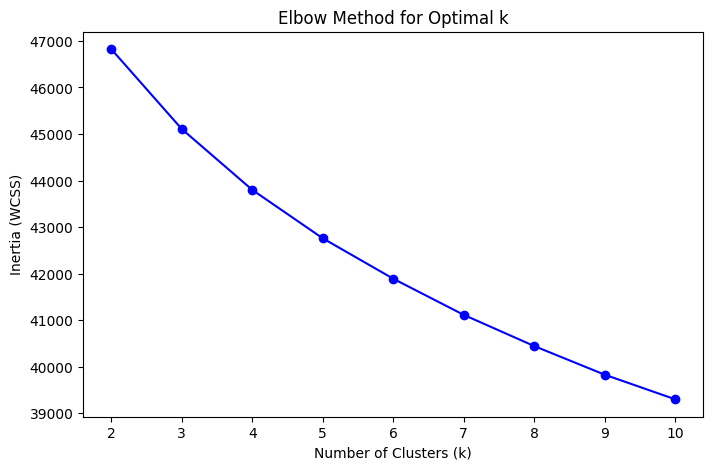

In [8]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Preprocess the data
X_processed = preprocessor.fit_transform(df)

inertia = []
K = range(2, 11)  # test clusters from 2 to 10

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_processed)
    inertia.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(8,5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.show()

In [9]:
from sklearn.metrics import silhouette_score

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_processed)
    score = silhouette_score(X_processed, labels)
    print(f"k={k}, Silhouette Score={score:.3f}")


k=2, Silhouette Score=0.098
k=3, Silhouette Score=0.067
k=4, Silhouette Score=0.059
k=5, Silhouette Score=0.053
k=6, Silhouette Score=0.051
k=7, Silhouette Score=0.052
k=8, Silhouette Score=0.051
k=9, Silhouette Score=0.050
k=10, Silhouette Score=0.052


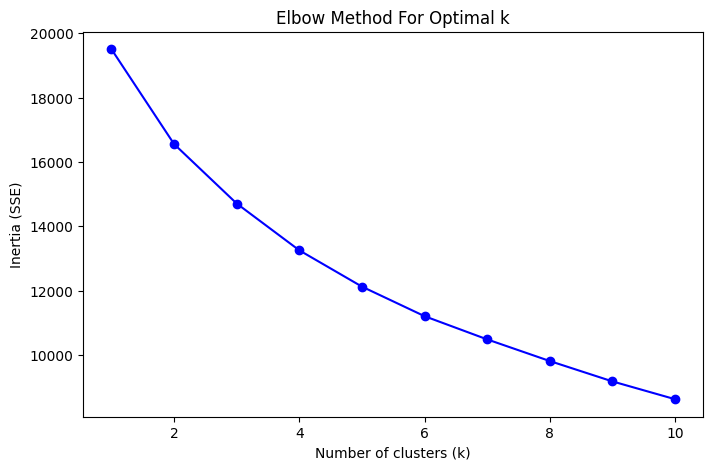

In [10]:
# ---------------------------
# STEP 2: Feature Engineering
# ---------------------------
from sklearn.preprocessing import StandardScaler

# Select only numeric features for clustering
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

X = df[numeric_cols]

# Standardize the data (important for K-Means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ---------------------------
# STEP 3: K-Means Segmentation
# ---------------------------
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Find the optimal k using Elbow Method
inertia = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (SSE)")
plt.title("Elbow Method For Optimal k")
plt.show()


In [11]:
# Fit KMeans with chosen k
final_k = 3  # try 2 and 4 as well
kmeans = KMeans(n_clusters=final_k, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# View cluster sizes
print(df['Cluster'].value_counts())


Cluster
1    1365
2    1353
0    1182
Name: count, dtype: int64


In [12]:
# Select only the required columns
numeric_cols = ['Age', 'Purchase Amount (USD)']
categorical_cols = ['Gender', 'Category', 'Item Purchased']

# Numeric features: cluster means
numeric_summary = df.groupby('Cluster')[numeric_cols].mean()

# Categorical features: cluster modes
categorical_summary = df.groupby('Cluster')[categorical_cols].agg(lambda x: x.value_counts().index[0])

# Combine numeric + categorical summaries
cluster_profile = pd.concat([numeric_summary, categorical_summary], axis=1)

cluster_profile


Age  Purchase Amount (USD) Gender  Category Item Purchased
Cluster                                                                  
0        45.727580              79.383249   Male  Clothing          Scarf
1        48.074725              37.221245   Male  Clothing           Coat
2        38.577236              65.368071   Male  Clothing         Jacket

In [13]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Assuming your data is X (scaled numeric features used for KMeans)
labels = kmeans.labels_

# 1. Silhouette Score: [-1, 1] → higher = better (close to 1 means well-clustered)
silhouette = silhouette_score(X, labels)

# 2. Davies-Bouldin Index: lower = better
db_index = davies_bouldin_score(X, labels)

# 3. Calinski-Harabasz Index: higher = better
ch_index = calinski_harabasz_score(X, labels)

print(f"Silhouette Score: {silhouette:.3f}")
print(f"Davies-Bouldin Index: {db_index:.3f}")
print(f"Calinski-Harabasz Index: {ch_index:.3f}")


Silhouette Score: -0.036
Davies-Bouldin Index: 9.631
Calinski-Harabasz Index: 46.441


**AGGLOMERATIVE CLUSTERING**

In [14]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Select only needed features
features = ["Age", "Gender", "Category", "Item Purchased", "Purchase Amount (USD)"  ]
df_selected = df[features].copy()

# Encode categorical variables
le_dict = {}
for col in ["Gender", "Category", "Item Purchased"]:
    le = LabelEncoder()
    df_selected[col] = le.fit_transform(df_selected[col])
    le_dict[col] = le  # store encoders in case you want to inverse transform later

# Scale numeric variables
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_selected)

# Apply Agglomerative Clustering
agg = AgglomerativeClustering(n_clusters=4, linkage='ward')  # try 3 clusters first
df['Cluster'] = agg.fit_predict(df_scaled)

# Validation metrics
silhouette = silhouette_score(df_scaled, df['Cluster'])
db_index = davies_bouldin_score(df_scaled, df['Cluster'])
ch_index = calinski_harabasz_score(df_scaled, df['Cluster'])

print("Silhouette Score:", silhouette)
print("Davies-Bouldin Index:", db_index)
print("Calinski-Harabasz Index:", ch_index)

# Cluster profile summary
numeric_summary = df.groupby('Cluster')[["Age", "Purchase Amount (USD)"]].mean()
categorical_summary = df.groupby('Cluster')[["Gender", "Category", "Item Purchased"]].agg(lambda x: x.value_counts().index[0])
cluster_profile = pd.concat([numeric_summary, categorical_summary], axis=1)

print("\nCluster Profile:")
print(cluster_profile)


Silhouette Score: 0.198470716002094
Davies-Bouldin Index: 1.6066344052881965
Calinski-Harabasz Index: 800.1176458211625

Cluster Profile:
               Age  Purchase Amount (USD)  Gender     Category Item Purchased
Cluster                                                                      
0        43.583677              58.358615    Male  Accessories        Jewelry
1        43.996513              60.409765  Female     Clothing         Blouse
2        44.555099              61.248355    Male     Clothing        Sweater
3        44.311728              57.172840    Male    Outerwear         Jacket


**DBSCAN**

In [16]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Scale features (important for DBSCAN)
X_scaled = StandardScaler().fit_transform(X)  # X is your numeric feature matrix

# Run DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)  # eps = neighborhood radius, min_samples = min pts to form a cluster
labels = dbscan.fit_predict(X_scaled)

# Count clusters (ignoring noise)
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print("Estimated number of clusters:", n_clusters)

# Evaluate only if we have >1 cluster and at least 2 samples per cluster (excluding noise)
if n_clusters > 1 and len([c for c in set(labels) if list(labels).count(c) > 1]) >= 2:
    print("Silhouette Score:", silhouette_score(X_scaled[labels != -1], labels[labels != -1]))
    # Davies-Bouldin and Calinski-Harabasz are not defined for noise points (-1)
    if n_clusters > 1: # Ensure there are at least 2 clusters excluding noise
        print("Davies-Bouldin Index:", davies_bouldin_score(X_scaled[labels != -1], labels[labels != -1]))
        print("Calinski-Harabasz Index:", calinski_harabasz_score(X_scaled[labels != -1], labels[labels != -1]))
else:
    print("Not enough clusters (excluding noise) to compute evaluation metrics.")


# Check cluster distribution
import pandas as pd
df_with_clusters = df.copy() # Create a copy to avoid modifying the original df in place
df_with_clusters["Cluster"] = labels

# Select only numeric columns for mean calculation
numeric_cols = df_with_clusters.select_dtypes(include=['int64', 'float64']).columns
print("\nCluster Mean Profile:")
print(df_with_clusters.groupby("Cluster")[numeric_cols].mean())

Estimated number of clusters: 55
Silhouette Score: 0.5092649894852006
Davies-Bouldin Index: 0.6611639918135774
Calinski-Harabasz Index: 140.0657909870317

Cluster Mean Profile:
         Customer ID        Age  Purchase Amount (USD)  Review Rating  \
Cluster                                                                 
-1       1937.582381  44.032060              59.977976       3.751408   
 0        143.000000  36.800000              70.200000       4.600000   
 1        320.600000  67.600000              25.000000       4.500000   
 2        367.400000  25.200000              42.400000       4.300000   
 3        467.800000  36.000000              39.200000       3.400000   
 4        419.000000  30.400000              64.600000       3.360000   
 5        697.666667  28.888889              80.666667       3.033333   
 6        667.400000  52.600000              89.400000       4.340000   
 7        750.000000  62.400000              57.800000       3.200000   
 8        942.800000

In [17]:
# Numeric cluster means
numeric_cols = df.select_dtypes(include=['int64','float64']).columns
numeric_summary = df.groupby("Cluster")[numeric_cols].mean()

# Categorical cluster modes
categorical_cols = df.select_dtypes(include=['object']).columns
categorical_summary = df.groupby("Cluster")[categorical_cols].agg(lambda x: x.value_counts().index[0])

# Combine results
cluster_profile = pd.concat([numeric_summary, categorical_summary], axis=1)
cluster_profile


Customer ID        Age  Purchase Amount (USD)  Review Rating  \
Cluster                                                                 
-1       1937.582381  44.032060              59.977976       3.751408   
 0        143.000000  36.800000              70.200000       4.600000   
 1        320.600000  67.600000              25.000000       4.500000   
 2        367.400000  25.200000              42.400000       4.300000   
 3        467.800000  36.000000              39.200000       3.400000   
 4        419.000000  30.400000              64.600000       3.360000   
 5        697.666667  28.888889              80.666667       3.033333   
 6        667.400000  52.600000              89.400000       4.340000   
 7        750.000000  62.400000              57.800000       3.200000   
 8        942.800000  40.600000              27.800000       4.260000   
 9        988.666667  47.666667              33.833333       2.716667   
 10      1040.571429  59.428571              25.714286       3.214286   
 11      1020.800000  26.600000              63.200000       4.360000   
 12      1252.777778  63.444444              54.888889       3.788889   
 13      1101.250000  66.625000              92.375000       4.037500   
 14      1290.400000  41.400000              56.000000       3.920000   
 15      1267.400000  28.000000              80.600000       4.520000   
 16      1213.250000  67.000000              61.250000       4.275000   
 17      1465.200000  64.400000              36.000000       3.240000   
 18      1636.000000  35.833333              77.666667       3.833333   
 19      1494.200000  29.000000              64.800000       4.100000   
 20      1569.000000  38.800000              72.800000       3.240000   
 21      1688.000000  60.000000              37.000000       3.425000   
 22      1714.400000  34.200000              57.000000       3.300000   
 23      1941.000000  53.400000              38.800000       3.080000   
 24      2211.400000  64.400000              33.800000       4.480000   
 25      2071.600000  61.000000              31.600000       2.720000   
 26      2285.375000  52.000000              93.125000       4.012500   
 27      2094.400000  26.200000              29.200000       3.760000   
 28      2023.000000  43.000000              73.000000       3.440000   
 29      2050.400000  39.800000              73.800000       4.700000   
 30      2233.600000  24.400000              92.000000       2.980000   
 31      2371.600000  29.200000              40.800000       3.820000   
 32      2459.400000  20.400000              34.200000       4.300000   
 33      2473.400000  45.600000              46.400000       4.160000   
 34      2608.800000  61.200000              51.200000       3.200000   
 35      2697.571429  60.571429              79.428571       3.014286   
 36      2672.600000  56.400000              24.600000       3.820000   
 37      2585.400000  26.600000              82.800000       3.320000   
 38      2828.400000  48.200000              31.000000       2.740000   
 39      2759.600000  35.800000              87.400000       3.880000   
 40      2938.400000  34.400000              34.400000       3.420000   
 41      3081.857143  57.285714              25.428571       4.571429   
 42      2901.000000  62.000000              45.400000       2.780000   
 43      3045.400000  41.200000              40.000000       2.720000   
 44      3237.375000  32.500000              64.000000       4.575000   
 45      3262.000000  25.200000              80.800000       4.040000   
 46      3487.444444  48.000000              71.888889       4.411111   
 47      3420.750000  45.250000              42.500000       3.075000   
 48      3537.333333  31.166667              72.333333       3.000000   
 49      3497.250000  60.375000              34.125000       3.437500   
 50      3704.333333  29.500000              87.000000       4.266667   
 51      3635.600000  36.000000              31.800000       4.5800

In [18]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

X = df_scaled  # your normalized data

# Try with 2 clusters first
gmm = GaussianMixture(n_components=2, random_state=42)
clusters = gmm.fit_predict(X)

df["Cluster"] = clusters

# Evaluation
silhouette = silhouette_score(X, clusters)
db_index = davies_bouldin_score(X, clusters)
ch_index = calinski_harabasz_score(X, clusters)

print(f"Silhouette Score: {silhouette}")
print(f"Davies-Bouldin Index: {db_index}")
print(f"Calinski-Harabasz Index: {ch_index}")


Silhouette Score: 0.15241023024321998
Davies-Bouldin Index: 2.302138375781793
Calinski-Harabasz Index: 696.1579977646701


**Taking all the col**

In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# ===== 1. Load Data =====
# replace with your actual dataset file
df = pd.read_csv("/content/shopping_behavior_updated.csv")

# ===== 2. Encode categorical variables =====
# Automatically encode all categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# ===== 3. Scale the data =====
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# ===== 4. Run KMeans for multiple k =====
results = {}
for k in range(2, 7):  # you can expand range
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(scaled_data)

    sil = silhouette_score(scaled_data, labels)
    db = davies_bouldin_score(scaled_data, labels)
    ch = calinski_harabasz_score(scaled_data, labels)

    results[k] = {
        "Silhouette": sil,
        "Davies-Bouldin": db,
        "Calinski-Harabasz": ch
    }

# ===== 5. Display results =====
print("Cluster Evaluation Metrics:")
for k, metrics in results.items():
    print(f"\nK = {k}")
    print(f"  Silhouette Score: {metrics['Silhouette']:.4f}")
    print(f"  Davies-Bouldin Index: {metrics['Davies-Bouldin']:.4f}")
    print(f"  Calinski-Harabasz Index: {metrics['Calinski-Harabasz']:.4f}")


Cluster Evaluation Metrics:

K = 2
  Silhouette Score: 0.1884
  Davies-Bouldin Index: 1.9710
  Calinski-Harabasz Index: 968.8688

K = 3
  Silhouette Score: 0.1178
  Davies-Bouldin Index: 2.7442
  Calinski-Harabasz Index: 624.2637

K = 4
  Silhouette Score: 0.0974
  Davies-Bouldin Index: 3.0248
  Calinski-Harabasz Index: 490.5624

K = 5
  Silhouette Score: 0.0798
  Davies-Bouldin Index: 3.2933
  Calinski-Harabasz Index: 395.3769

K = 6
  Silhouette Score: 0.0768
  Davies-Bouldin Index: 3.5535
  Calinski-Harabasz Index: 334.0764


**PCA + K-means**

In [20]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

df = pd.read_csv("/content/shopping_behavior_updated.csv")

# 1️⃣ Convert categorical columns into numeric (One-Hot Encoding)
df_encoded = pd.get_dummies(df, drop_first=True)

# 2️⃣ Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded)


# ✅ Apply PCA (reduce to 2 or 3 dimensions first, can try more later)
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total variance explained:", pca.explained_variance_ratio_.sum())

# ---------- KMeans after PCA ----------
kmeans = KMeans(n_clusters=3, random_state=42)
labels_kmeans = kmeans.fit_predict(X_pca)

print("\nKMeans after PCA:")
print("Silhouette Score:", silhouette_score(X_pca, labels_kmeans))
print("Davies-Bouldin Index:", davies_bouldin_score(X_pca, labels_kmeans))
print("Calinski-Harabasz Index:", calinski_harabasz_score(X_pca, labels_kmeans))

# ---------- Agglomerative after PCA ----------
agg = AgglomerativeClustering(n_clusters=3)
labels_agg = agg.fit_predict(X_pca)

print("\nAgglomerative after PCA:")
print("Silhouette Score:", silhouette_score(X_pca, labels_agg))
print("Davies-Bouldin Index:", davies_bouldin_score(X_pca, labels_agg))
print("Calinski-Harabasz Index:", calinski_harabasz_score(X_pca, labels_agg))


Explained variance ratio: [0.0305135  0.01903449 0.01680272]
Total variance explained: 0.06635071394215365

KMeans after PCA:
Silhouette Score: 0.500045125450668
Davies-Bouldin Index: 0.844379455899189
Calinski-Harabasz Index: 2611.338302431615

Agglomerative after PCA:
Silhouette Score: 0.48159200271905744
Davies-Bouldin Index: 0.9645976004311194
Calinski-Harabasz Index: 2203.9319870441495


**UMAP + K-Means + HDBSCAN**

In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import umap.umap_ as umap
import hdbscan

# ✅ Copy df and encode categorical columns
df_encoded = df.copy()
for col in df_encoded.select_dtypes(include=['object']).columns:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col])

# ✅ Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded)

# ✅ UMAP (nonlinear reduction to 2D)
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
X_umap = umap_model.fit_transform(X_scaled)

print("UMAP shape:", X_umap.shape)

# ---------- KMEANS on UMAP ----------
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(X_umap)

print("\nKMeans after UMAP:")
print("Silhouette Score:", silhouette_score(X_umap, kmeans_labels))
print("Davies-Bouldin Index:", davies_bouldin_score(X_umap, kmeans_labels))
print("Calinski-Harabasz Index:", calinski_harabasz_score(X_umap, kmeans_labels))

# ---------- HDBSCAN on UMAP ----------
hdb = hdbscan.HDBSCAN(min_cluster_size=20, min_samples=10, metric='euclidean')
hdb_labels = hdb.fit_predict(X_umap)

# Filter noise points (-1) if exist
mask = hdb_labels != -1
if mask.sum() > 0:
    print("\nHDBSCAN after UMAP (excluding noise):")
    print("Silhouette Score:", silhouette_score(X_umap[mask], hdb_labels[mask]))
    print("Davies-Bouldin Index:", davies_bouldin_score(X_umap[mask], hdb_labels[mask]))
    print("Calinski-Harabasz Index:", calinski_harabasz_score(X_umap[mask], hdb_labels[mask]))
    print("Number of clusters found:", len(set(hdb_labels)) - (1 if -1 in hdb_labels else 0))
else:
    print("HDBSCAN found only noise points. Try smaller min_cluster_size or lower min_samples.")


/usr/local/lib/python3.12/dist-packages/hdbscan/plots.py:448: SyntaxWarning: invalid escape sequence '\l'
  axis.set_ylabel('$\lambda$ value')
/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP shape: (3900, 2)

KMeans after UMAP:
Silhouette Score: 0.692086
Davies-Bouldin Index: 0.6941924503923749
Calinski-Harabasz Index: 81161.57

HDBSCAN after UMAP (excluding noise):


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Silhouette Score: 0.80919486
Davies-Bouldin Index: 0.27739105305003725
Calinski-Harabasz Index: 99019.83
Number of clusters found: 4


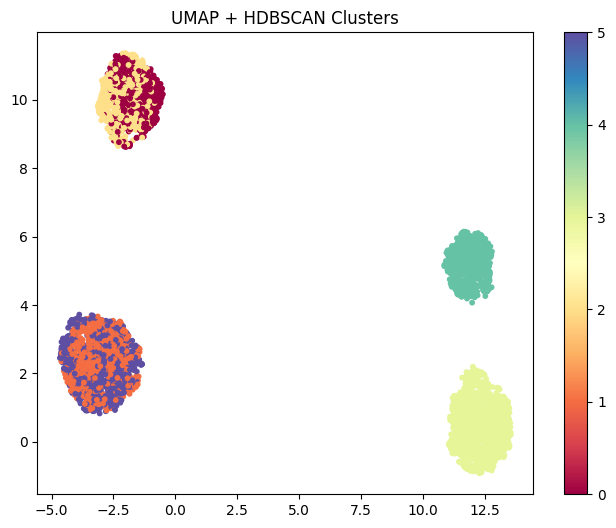

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(X_umap[:,0], X_umap[:,1], c=labels, cmap="Spectral", s=10)
plt.colorbar()
plt.title("UMAP + HDBSCAN Clusters")
plt.show()


**PROPENSITY MODELING**


Logistic Regression Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       854
           1       0.98      0.99      0.99       316

    accuracy                           0.99      1170
   macro avg       0.99      0.99      0.99      1170
weighted avg       0.99      0.99      0.99      1170

ROC-AUC: 0.9998777161829662

Random Forest Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       854
           1       1.00      1.00      1.00       316

    accuracy                           1.00      1170
   macro avg       1.00      1.00      1.00      1170
weighted avg       1.00      1.00      1.00      1170

ROC-AUC: 1.0


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [11:33:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       854
           1       1.00      1.00      1.00       316

    accuracy                           1.00      1170
   macro avg       1.00      1.00      1.00      1170
weighted avg       1.00      1.00      1.00      1170

ROC-AUC: 0.9999814721489342


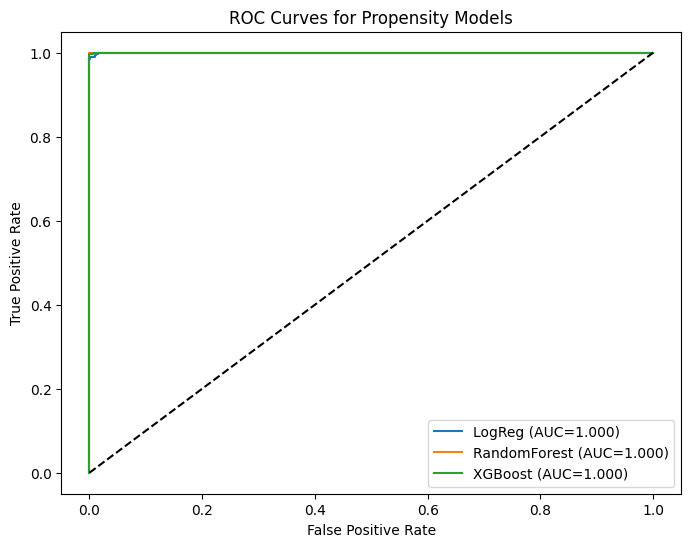

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# ✅ Load dataset
df = pd.read_csv("shopping_behavior_updated.csv")

# 1️⃣ Define target variable (example: Subscription Status as churn indicator)
target = "Subscription Status"
df[target] = LabelEncoder().fit_transform(df[target])  # Yes=1, No=0

# 2️⃣ Encode categorical features
df_encoded = df.copy()
for col in df_encoded.select_dtypes(include=['object']).columns:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col])

# 3️⃣ Split into features + target
X = df_encoded.drop(columns=[target])
y = df_encoded[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 4️⃣ Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ---------- Logistic Regression ----------
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
print("\nLogistic Regression Report:")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, lr.predict_proba(X_test_scaled)[:,1]))

# ---------- Random Forest ----------
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("\nRandom Forest Report:")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))

# ---------- XGBoost ----------
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print("\nXGBoost Report:")
print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, xgb.predict_proba(X_test)[:,1]))

# ---------- Plot ROC Curves ----------
plt.figure(figsize=(8,6))
for model, name in [(lr, "LogReg"), (rf, "RandomForest"), (xgb, "XGBoost")]:
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test_scaled if name=="LogReg" else X_test)[:,1])
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_test, model.predict_proba(X_test_scaled if name=='LogReg' else X_test)[:,1]):.3f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Propensity Models")
plt.legend()
plt.show()



Logistic Regression Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       667
           1       1.00      1.00      1.00       503

    accuracy                           1.00      1170
   macro avg       1.00      1.00      1.00      1170
weighted avg       1.00      1.00      1.00      1170

ROC-AUC: 1.0

Random Forest Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       667
           1       1.00      1.00      1.00       503

    accuracy                           1.00      1170
   macro avg       1.00      1.00      1.00      1170
weighted avg       1.00      1.00      1.00      1170

ROC-AUC: 1.0

XGBoost Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       667
           1       1.00      1.00      1.00       503

    accuracy                           1.00      1170
   macro avg       1.00      1.00

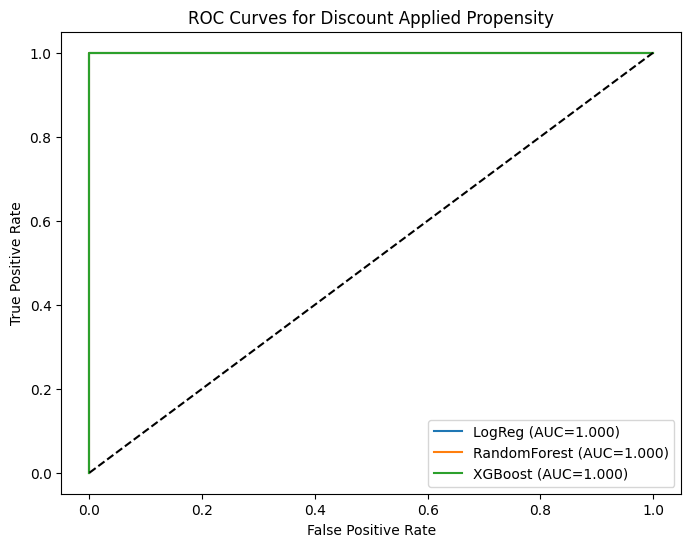

In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# ✅ Load dataset
df = pd.read_csv("shopping_behavior_updated.csv")

# 1️⃣ Define target variable (Discount Applied)
target = "Discount Applied"
df[target] = LabelEncoder().fit_transform(df[target])  # Yes=1, No=0

# 2️⃣ Encode categorical features
df_encoded = df.copy()
for col in df_encoded.select_dtypes(include=['object']).columns:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col])

# 3️⃣ Split into features + target
X = df_encoded.drop(columns=[target])
y = df_encoded[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 4️⃣ Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ---------- Logistic Regression ----------
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
print("\nLogistic Regression Report:")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, lr.predict_proba(X_test_scaled)[:,1]))

# ---------- Random Forest ----------
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("\nRandom Forest Report:")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))

# ---------- XGBoost ----------
xgb = XGBClassifier(eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print("\nXGBoost Report:")
print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, xgb.predict_proba(X_test)[:,1]))

# ---------- Plot ROC Curves ----------
plt.figure(figsize=(8,6))
for model, name in [(lr, "LogReg"), (rf, "RandomForest"), (xgb, "XGBoost")]:
    proba = model.predict_proba(X_test_scaled if name=="LogReg" else X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_test, proba):.3f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Discount Applied Propensity")
plt.legend()
plt.show()



Logistic Regression Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       806
           1       0.99      1.00      0.99       364

    accuracy                           1.00      1170
   macro avg       0.99      1.00      1.00      1170
weighted avg       1.00      1.00      1.00      1170

ROC-AUC: 0.999982957489161

Random Forest Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       806
           1       1.00      1.00      1.00       364

    accuracy                           1.00      1170
   macro avg       1.00      1.00      1.00      1170
weighted avg       1.00      1.00      1.00      1170

ROC-AUC: 1.0

XGBoost Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       806
           1       1.00      1.00      1.00       364

    accuracy                           1.00      1170
   macro avg       

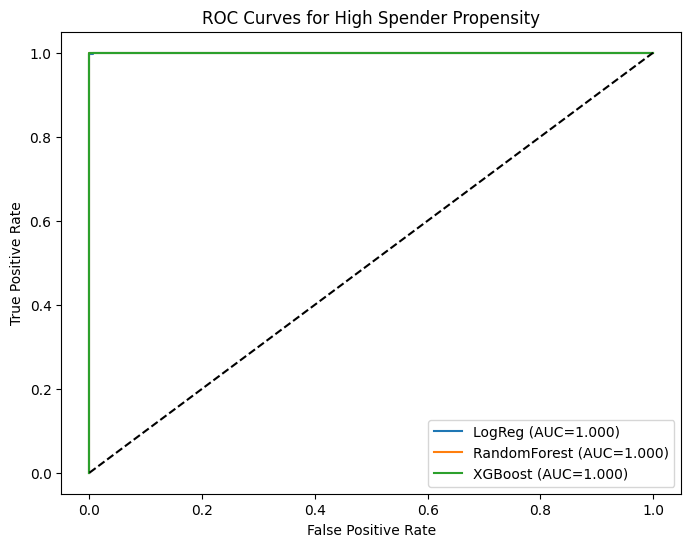

In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# ✅ Load dataset
df = pd.read_csv("shopping_behavior_updated.csv")

# 1️⃣ Create High Spender target
threshold = 75  # you can adjust this
df['High_Spender'] = (df['Purchase Amount (USD)'] > threshold).astype(int)

target = "High_Spender"

# 2️⃣ Encode categorical features
df_encoded = df.copy()
for col in df_encoded.select_dtypes(include=['object']).columns:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col])

# 3️⃣ Split into features + target
X = df_encoded.drop(columns=[target])
y = df_encoded[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 4️⃣ Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ---------- Logistic Regression ----------
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
print("\nLogistic Regression Report:")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, lr.predict_proba(X_test_scaled)[:,1]))

# ---------- Random Forest ----------
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("\nRandom Forest Report:")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))

# ---------- XGBoost ----------
xgb = XGBClassifier(eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print("\nXGBoost Report:")
print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, xgb.predict_proba(X_test)[:,1]))

# ---------- Plot ROC Curves ----------
plt.figure(figsize=(8,6))
for model, name in [(lr, "LogReg"), (rf, "RandomForest"), (xgb, "XGBoost")]:
    proba = model.predict_proba(X_test_scaled if name=="LogReg" else X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_test, proba):.3f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for High Spender Propensity")
plt.legend()
plt.show()
